In [1]:
import os
import sys

import numpy as np
import mlx.core as mx
import mlx.nn as nn
import matplotlib.pyplot as plt
from PIL import Image

from softgrad import Network
from softgrad.Checkpoint import Checkpoint
from softgrad.layer.transform import Flatten
from softgrad.layer.shim import MLX
from softgrad.optim import SGD
from softgrad.function.activation import leaky_relu, softmax
from softgrad.function.loss import CrossEntropyLoss, cross_entropy_loss
from softgrad.layer.core import Linear, Activation

sys.path.append(os.path.abspath('..'))
from util.dataset import get_cifar10

In [2]:
# load model from checkpoint
network = Network(input_shape=(32, 32, 3))

# conv block 1
network.add_layer(MLX(nn.Conv2d(in_channels=3, out_channels=96, kernel_size=7)))
network.add_layer(Activation(leaky_relu))
network.add_layer(MLX(nn.MaxPool2d(2)))
# conv block 2
network.add_layer(MLX(nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3)))
network.add_layer(Activation(leaky_relu))
network.add_layer(MLX(nn.MaxPool2d(2)))
# feed forward
network.add_layer(Flatten())
network.add_layer(Linear(1024))
network.add_layer(Activation(leaky_relu))
network.add_layer(Linear(10))

network.load(Checkpoint.read("checkpoints/simple_conv.pb"))

In [3]:
def normalize(x):
    min_x = mx.min(x)
    x -= min_x

    max_x = mx.max(x)
    x /= max_x

    return x

def viz_input(x):
    x = 255 * np.array(x[0])
    img_x = Image.fromarray(x.astype('uint8'))
    plt.imshow(img_x)

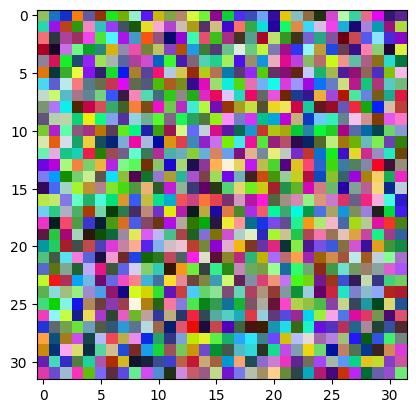

In [4]:
# create some noise
noise = mx.random.uniform(0, 1, (1, 32, 32, 3))
viz_input(noise)

In [5]:
# prepare to optimize the input image (noise)
network.freeze()
optimizer = SGD(eta=0.05, momentum=0.9, weight_decay=0.0005)
optimizer.bind_network(network)
optimizer.bind_loss_fn(cross_entropy_loss)

In [6]:
# Cifar-10 labels
#   0 -> Airplane
#   1 -> Automobile
#   2 -> Bird
#   3 -> Cat
#   4 -> Deer
#   5 -> Dog
#   6 -> Frog
#   7 -> Horse
#   8 -> Ship
#   9 -> Truck

[[4.0961607e-09 7.3568841e-17 9.9992144e-01 2.7796646e-05 6.7975679e-07
  1.1233657e-05 3.8257262e-05 5.6666391e-07 9.9077512e-15 7.8040394e-11]]


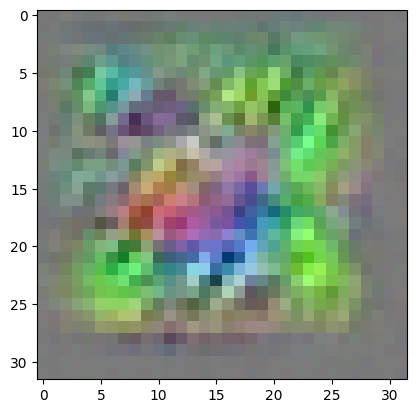

In [19]:
# Generate from noise
x = mx.random.uniform(0, 0.0001, (1, 32, 32, 3))

y = np.zeros((1, 10))  # one-hot encoded label
y[0][2] = 1

for i in range(10000):
    grad = optimizer.step(x, y)
    x -= 0.001 * grad
    x = normalize(x)

viz_input(x)
print(np.array(softmax(network.forward(x))))

In [8]:
# load data
train, test = get_cifar10()
train, test = list(train), list(test)

[[3.1943410e-15 2.7121853e-27 3.6645334e-10 1.0038401e-17 1.1748098e-22
  2.3106256e-27 1.0000000e+00 1.3676679e-29 2.5697975e-18 1.5408515e-22]]


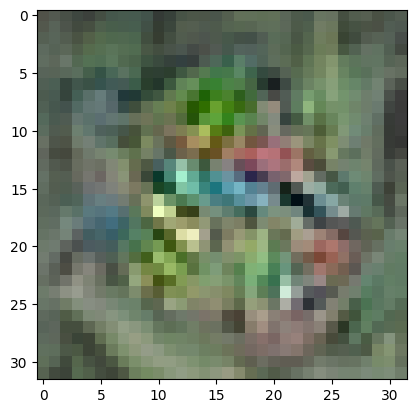

In [18]:
# Enhance existing image
x = test[4]['image']
x = mx.array(x.reshape((1, *x.shape)))
y = test[4]['label']
y = mx.array(y.reshape((1, *y.shape)))

for i in range(1000):
    grad = optimizer.step(x, y)
    x -= 0.1 * grad
    x = normalize(x)

viz_input(x)
print(np.array(softmax(network.forward(x))))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


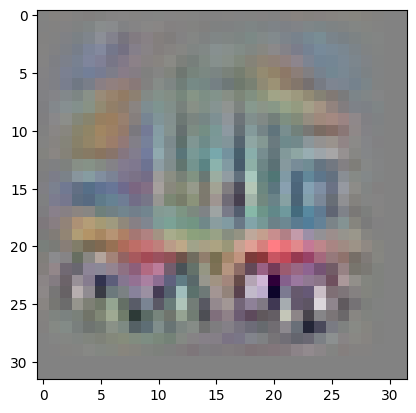

In [30]:
# Better visualization from noise
# x = mx.random.uniform(0, 1, (1, 32, 32, 3))
x = mx.random.normal((1, 32, 32, 3))

y = np.zeros((1, 10))  # one-hot encoded label
y[0][9] = 9

for i in range(500):
    grad = optimizer.step(x, y)
    x -= 2.5 * grad + 0.2 * x

# x = 2.5 * x + 0.5
x = normalize(x)
viz_input(x)
print(np.array(softmax(network.forward(x))))

In [11]:
noise = mx.random.normal((1, 32, 32, 3))
y = network.forward(noise)
np.array(softmax(y))

array([[0.0000000e+00, 9.9999833e-01, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.6356209e-06, 3.1288960e-38,
        0.0000000e+00, 5.7839298e-15]], dtype=float32)